In [2]:
from matplotlib.pyplot import subplots, savefig
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import richardsplot as rplot

from utilities.analysis import plotting
from utilities.ccd import CCD
from utilities.containers import *
from utilities.conversions import magToFlux

/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/astropy/table/np_utils.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _np_utils
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/astropy/io/ascii/fastbasic.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import cparser
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
cmap = rplot.palettable.colorbrewer.diverging.PuOr_11.mpl_colormap

In [4]:
pixmapfile = "/media/jackeline/UUI/PixelMaps/K2_target_pixels.hdf5"

#  Make CCD using PixelMapContainer and PixelMapGenerator

In [38]:
ccd = CCD(module=11, channel=1, field='FLUX', campaign=8)
cont = PixelMapContainer.from_hdf5(pixmapfile, ccd)
cont.save(pixmapfile)
                        
gen = PixMapGenerator(cont)
print "Finished Making", ccd
            

  Writing... (Do Not Turn off Device or Stop Kernel)

Finished Making CCD(module=11, channel=1, field='FLUX', campaign=8)


Plotting first lc in container 

# tracking pixels


# Removed source pixels

In [39]:
'''
pixellc.py

functions for generating custom representations of K2 "Pixel Light Curves"
from PixMapGenerators to be sent to functions for plotting or further analysis
'''

from itertools import izip, imap, ifilter
import numpy as np


def New_get_pixel_lc(gen, percentiles, flux_range=None, mag_range=None,static = False, stat_funcs=None):
    if flux_range is not None:
        lower, higher = sorted(flux_range)

    if stat_funcs is None:
        stat_funcs = (np.median,)

    ccd = gen.ccd
    N = gen.N
    M = len(percentiles)-1
    L = len(stat_funcs)

    #lc = np.empty((N, M, L+2))
    lc = np.empty((N,M,5)) # min, max, var, median, mean
    lc[::] = np.nan
    #lc[::] = np.nan


    l_bin_edges = np.empty((gen.N, len(percentiles)))
    def _get_epochs():
        if flux_range is not None:
            return _get_filtered_epochs()

        return _get_full_epochs()

    def _get_full_epochs():
        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

                yield g

    def _get_filtered_epochs():
        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

            mask = (g > lower) & (g < higher)
            yield g[mask]

    epochs = list(_get_epochs())

    '''percentiles is a flat array of percentiles ranging from 0 to 100'''
    N = gen.N
    higher, lower = None, None
    if mag_range is None:
        higher, lower = np.inf, -np.inf
        mag_range = (lower, higher)
    else:
        higher, lower = magToFlux(np.array(sorted(mag_range)))
    if np.inf in mag_range:
        lower = -np.inf
        
        
    pixel_median_flux = []
    allpixel = []
    source_pix_mask = np.array([])
    for i in range(len(gen.containers.containers[:])):
        pix_t_index = np.shape(gen.containers.containers[i].pixels)[0]
        pix_row = np.shape(gen.containers.containers[i].pixels)[1]
        pix_column = np.shape(gen.containers.containers[i].pixels)[2]
        for r in range (pix_row):
            for c in range (pix_column):
                fluxes = gen.containers.containers[i].pixels[:,r,c]
                #stack all pixels all at epoch = l index 
                allpixel.append(fluxes)
                #mask = (fluxes > lower) & (fluxes < higher)
                pixel_median_flux.append(np.nanmedian(fluxes))
        
        max_flux = np.nanpercentile((np.array(pixel_median_flux)[(len(pixel_median_flux)-(pix_row * pix_column)):len(pixel_median_flux)] ),95)

        subset = (np.array(pixel_median_flux)[(len(pixel_median_flux)-(pix_row * pix_column)):len(pixel_median_flux)])
        smask = np.where(subset <= max_flux)[0]
        #mask bright pixels
        #smask = np.where(subset >= max_flux)[0]


        smask = (len(pixel_median_flux)-(pix_row * pix_column))+smask[:]

        source_pix_mask = np.append(source_pix_mask,smask)

            
    print("computed median fluxes for %d pixels" %len(pixel_median_flux)) 
    
    #remove neg flux pixels and nans
  
    pixel_median_flux = np.delete(pixel_median_flux,source_pix_mask)
    keep = np.where(np.isnan(np.array(pixel_median_flux)[:])==False)[0] 
    print('Removing %d pixels due to negative flux or NANs' %(len(pixel_median_flux)-len(keep)))
    
    #assign pixel a percentile based on median
    percentile_bin_edges = np.nanpercentile(np.array(pixel_median_flux)[keep], percentiles, axis=0).T
    percentile_bin_edges[-1]  += 1e-10  
    indices = np.digitize(np.array(pixel_median_flux), percentile_bin_edges)-1 
    print("NUmber of pixels in percentile%d"%len(np.array(pixel_median_flux)[keep]))
    
    

    for i,g in enumerate((gen.get_unordered(i) for i in xrange(N))):
        #max_flux = np.nanpercentile((np.array(pixel_median_flux[keep])[(len(pixel_median_flux)-(pix_row * pix_column)):len(pixel_median_flux)] ),5)

        #print('before %d'%len(g))
        g = np.delete(g,source_pix_mask.astype('int'))
        #print('after %d'%len(g))
        m = (g > lower) & (g < higher)
        
        if m.any():
            pixels_g = g[m]

            #********Pixel Position and Median FLux Dependence*****
            if static == True:
                g_index = indices[m]
            else:
            #********Flux Dependence*****
                percentile_bin_edges = np.percentile(g[m], percentiles)
                g_index = np.digitize(pixels_g, percentile_bin_edges)-1
                
            unique_indices = np.unique(g_index)
            #print("number of percentile bins in this cadence %d" %len(unique_indices))
            for j, bin_num in enumerate(unique_indices[unique_indices<500]):
                cut = pixels_g[g_index == bin_num]
                if len(cut)>0:
                    lc[i,j,2] = np.var(cut)
                    lc[i,j,3] = np.median(cut)


    return lc


In [40]:
percentiles = np.linspace(0, 100, 501)
flux_range = map(magToFlux,(50,1))
lc = New_get_pixel_lc(gen,percentiles, flux_range = flux_range)


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in less_equal


computed median fluxes for 32802 pixels
Removing 999 pixels due to negative flux or NANs
NUmber of pixels in percentile1723


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:110: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


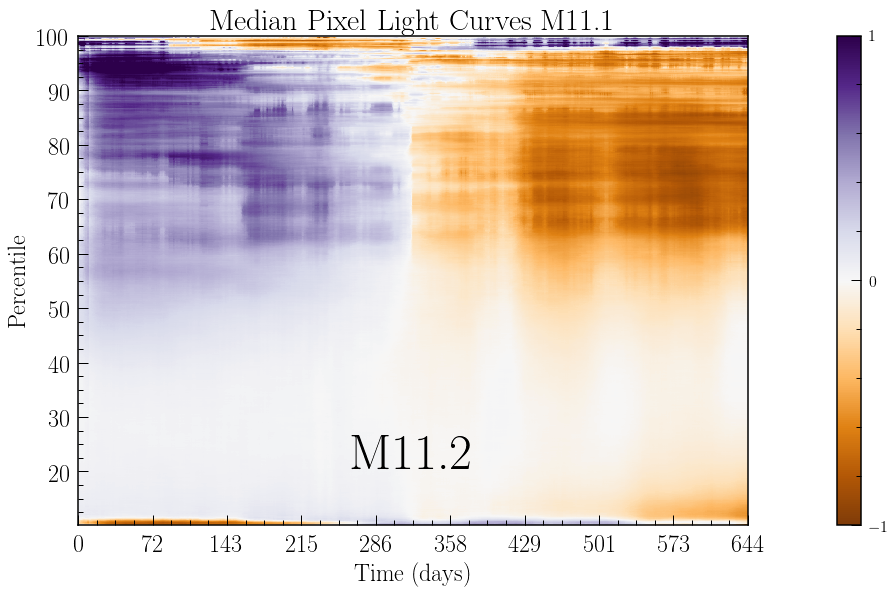

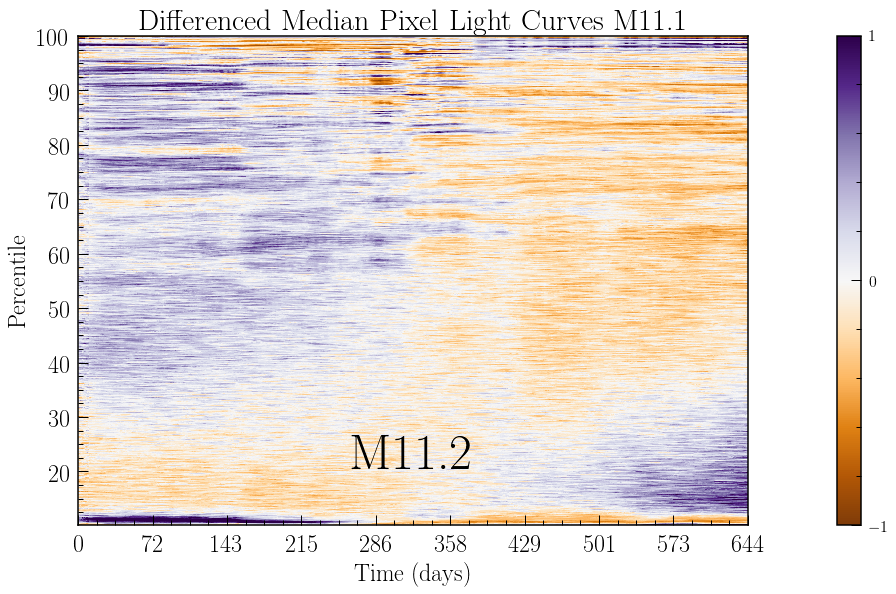

In [41]:
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,3], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
#savefig('plots/c{:02d}/Module{}Channel{}PixelMapFull.png'.format(ccd.campaign, ccd.module, ccd.channel))
    
#Make the differenced image map
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,3], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Differenced Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
#savefig('plots/c{:02d}/Module{}Channel{}PixelMapDiff.png'.format(ccd.campaign, ccd.module, ccd.channel))
    

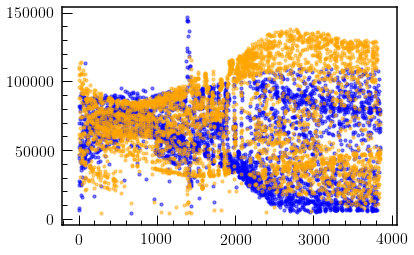

In [12]:
plt.scatter(xrange(len(lc[:,-1,3])),lc[:,-1,3]-lc[:,-2,3],s = 10,color = "blue", alpha = 0.5)
plt.scatter(xrange(len(lc[:,-2,3])),lc[:,-2,3]-lc[:,-3,3],s = 10,color = "orange", alpha = 0.5)

In [43]:
from utilities.analysis import plot_template

temp1 = plot_template.smooth_template(lc[:,:,3], smooth=200, image=True,differenced=True)

temp2 = plot_template.smooth_template(lc[:,:,3], smooth=500, image=True,differenced=True)

temp3 = plot_template.smooth_template(lc[:,:,3], smooth=1000, image=True,differenced=True)

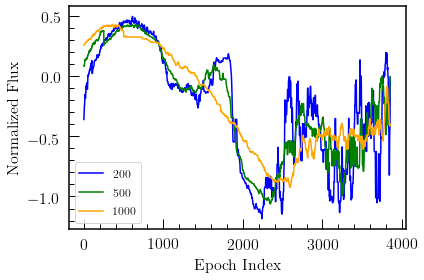

In [27]:
plt.plot(xrange(len(temp1[:,-1])),temp1[:,-1], color = "blue", label = "200")
plt.plot(xrange(len(temp2[:,-1])),temp2[:,-1], color =  "green", label = "500")
plt.plot(xrange(len(temp3[:,-1])),temp3[:,-1], color = "orange", label = "1000")
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()
plt.savefig('./plots/templateTest.png', dpi = 200)


In [ ]:
temp2_med = plot_template.smooth_template(lc[:,:,3], smooth=500, image=True,differenced=False)
temp2_diff = plot_template.smooth_template(lc[:,:,3], smooth=500, image=True,differenced=True)

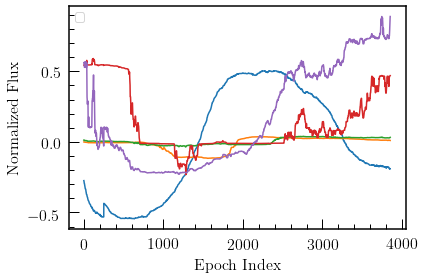

In [45]:
for i in range(0,5):
    plt.plot(xrange(len(temp2_med[:,-1*i])),temp2_med[:,-1*i])
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()

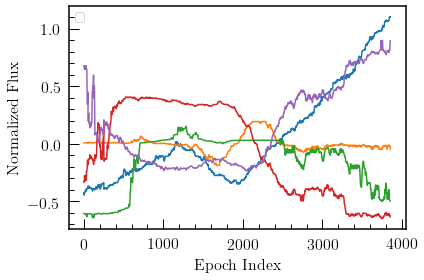

In [47]:
for i in range(0,5):
    plt.plot(xrange(len(temp2_diff[:,-1*i])),temp2_diff[:,-1*i])
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()